# Differentiable quenching model

The modeling ingredients in `differentiable_smhm` that we have discussed so far allow us to create a universe of galaxies at a single redshift, where the only attribute our galaxies have is $M_{\star}.$ The final ingredient of the model we'll discuss here is a binary designation for _quenching_. The primary purpose of following along this notebook is to demonstrate how the sigmoid-stitching technique works for the case of a three-dimensional problem. We won't use this quenching model in the time-evolving models that these techniques were built for, but "on vs. off" quenching is a simple problem and so is a good place to learn the 3d generalization of these methods. Once you see how to do this for 3 dimensions, you'll pretty much fully understand how the method works in its full N-dimensional generality. In practice, the galaxy--halo connection is reasonably sparse, and usually 2-3 dimensions is all that is needed to capture the bulk of the dependencies that regulate some phenomenon to within observationally-relevant levels of accuracy.

In our quenching model, we will map onto each simulated subhalo a value of $0\leq P_{\rm q}\leq 1,$ the probability that the galaxy is quenched. The purpose of this modeling ingredient is to enable us to calculate summary statistics of "quenched" and "not-quenched" subpopulations. The way the method works is that for a galaxy with quenching probability $P_{\rm q},$ the galaxy makes a _fractional_ contribution $P_{\rm q}$ to the quenched population, and a fractional contribution $P_{\rm q}$ to the non-quenched population. This is simple to do for one-point summary statistics such as histograms, but it can also be done for two-point summary statistics such as clustering and lensing (see the SHAMNet paper for details). 

In our model parametrization, we want to capture the following key facts about galaxies in the real universe:
1. $P_{\rm q}$ increases monotonically with $M_{\rm peak}.$
2. $P_{\rm q, cen}(M_{\rm peak})<=P_{\rm q, sat}(M_{\rm peak}).$ That is, for a central and satellite galaxy with the same same subhalo mass, the satellite is more likely to be quenched than the central.
3. Satellites with earlier infall times are more likely to be quenched than satellites with more recent infall times.
4. Satellites in host halos of larger mass are more likely to be quenched relative to satellites hosted by lower-mass hosts.

To capture all four of these dependencies at once, the `sigmoid_quenching` module build a parametric model for $P_{\rm q}(X_{\rm halo}\vert\theta_{\rm q}),$ where $X_{\rm halo}=\{M_{\rm peak}, M_{\rm host}, \Delta t_{\rm acc}\}.$ In the source code implementation, our parametrization starts out such that $P_{\rm q, cen}$ varies like a simple sigmoid function of $M_{\rm peak}:$
$$P_{\rm q, cen}(M_{\rm peak}) = p_{\rm low} + \frac{p_{\rm high} - p_{\rm low}}{1 + \exp\left[-k\cdot(m-m_0)\right]},$$
where $m\equiv\log_{10}M_{\rm peak}.$ Then, for satellites, what we actually parameterize is the _boost_, $\Delta P_{\rm q}(M_{\rm peak}),$ that enhances the quenching probability above what it would be if the satellites had been a central of mass $M_{\rm peak}.$ The boost $\Delta P_{\rm q, sat}$ has a lower bound at zero, so that satellites can never be _less_ likely to be quenched than a central of the same halo mass. The upper bound on the boost is then determined by another sigmoid function that controls the behavior with respect to $\Delta t_{\rm acc}$ and $M_{\rm host}.$ Let's use ${\rm dQ}$ to denote this "upper bound on boost." We model ${\rm dQ}$ to have a sigmoid dependence upon $\Delta t_{\rm acc},$ with additional modulating dependence from $M_{\rm host}.$ For all satellites, we should have ${\rm dQ}=0$ when $\Delta t_{\rm acc}<=0,$ since satellites that just fell in should not be any more likely to be quenched than their counterpart centrals. Moreover, once satellites have traversed an orbit or two, they've already gotten pretty much all the boost they're gonna get. So our choice to model ${\rm dQ}$ to be a sigmoid function of $\Delta t_{\rm acc}$ has a reasonable physical basis. The additional dependence of ${\rm dQ}$ upon $M_{\rm host}$ is simple enough: since ${\rm dQ}$ is modeled by a sigmoid, there is a single parameter $z$ that controls the asymptotic limit ${\rm dQ}(\Delta t_{\rm acc}\rightarrow\infty),$ and we elevate $z$ to have a sigmoid dependence: $z\rightarrow z(M_{\rm host}).$ 

### Warmup exercises

1. Fiddle around with the quenching model parameters and remake the plots below to build intuition behind what each parameter does. No need to go overboard here since we won't be using this model for our science applications. The main purpose of this exercise is to make sure you understand how these sigmoid-stitching tricks work for a reasonably complex model.

In [1]:
import matplotlib.cm as cm
from matplotlib import lines as mlines
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from differentiable_smhm.galhalo_models import sigmoid_quenching

In [3]:
n_colors = 500
colors = cm.coolwarm(np.linspace(0, 1, n_colors)) # blue first
n_h = 1_000
zz = np.zeros(n_h)

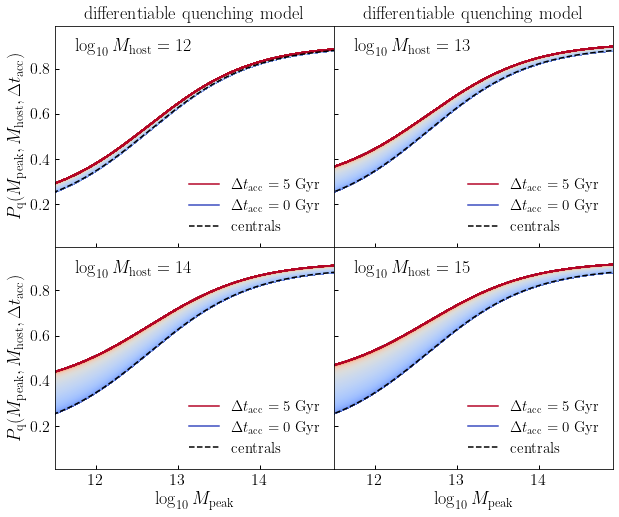

In [4]:
time_since_infall_arr = np.linspace(0, 5, n_colors)

blue_line = mlines.Line2D([],[],ls='-', c=colors[0], label=r'$\Delta t_{\rm acc}=0\ {\rm Gyr}$')
red_line = mlines.Line2D([],[],ls='-', c=colors[-1], label=r'$\Delta t_{\rm acc}=5\ {\rm Gyr}$')
black_line = mlines.Line2D([],[],ls='--', c='k', label=r'${\rm centrals}$')


fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
((ax0, ax1), (ax2, ax3)) = _axes
axes = ax0, ax1, ax2, ax3
fig.subplots_adjust(wspace=0, hspace=0)
ylim = ax0.set_ylim(0.01, 0.99)
xlim = ax0.set_xlim(11.5, 14.9)

lgmhost_plot = [12, 13, 14, 15]
a, b = 11.75, 0.875

lgmparr = np.linspace(10, 16, n_h)

for ax, lgmhost in zip(axes, lgmhost_plot):
    for t, c in zip(time_since_infall_arr, colors):
        qprob = sigmoid_quenching.quenching_prob_sats(lgmparr, lgmhost+zz, t)
        __=ax.plot(lgmparr, qprob, color=c)
    leg = ax.legend(handles=[red_line, blue_line, black_line], loc='lower right')
    __=ax.plot(lgmparr, sigmoid_quenching.quenching_prob_cens(lgmparr), '--', color='k')

__=ax0.annotate(r'$\log_{10}M_{\rm host}=12$', xy=(a, b), xytext=(a, b), size=18)
__=ax1.annotate(r'$\log_{10}M_{\rm host}=13$', xy=(a, b), xytext=(a, b), size=18)
__=ax2.annotate(r'$\log_{10}M_{\rm host}=14$', xy=(a, b), xytext=(a, b), size=18)
__=ax3.annotate(r'$\log_{10}M_{\rm host}=15$', xy=(a, b), xytext=(a, b), size=18)

title = ax0.set_title(r'${\rm differentiable\ quenching\ model}$')
title = ax1.set_title(r'${\rm differentiable\ quenching\ model}$')

xlabel = ax2.set_xlabel(r'$\log_{10}M_{\rm peak}$')
xlabel = ax3.set_xlabel(r'$\log_{10}M_{\rm peak}$')
ylabel = ax0.set_ylabel(r'$P_{\rm q}(M_{\rm peak}, M_{\rm host},\Delta t_{\rm acc})$')
ylabel = ax2.set_ylabel(r'$P_{\rm q}(M_{\rm peak}, M_{\rm host},\Delta t_{\rm acc})$')

fig.savefig('qprob_sats_vs_cens.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200) 

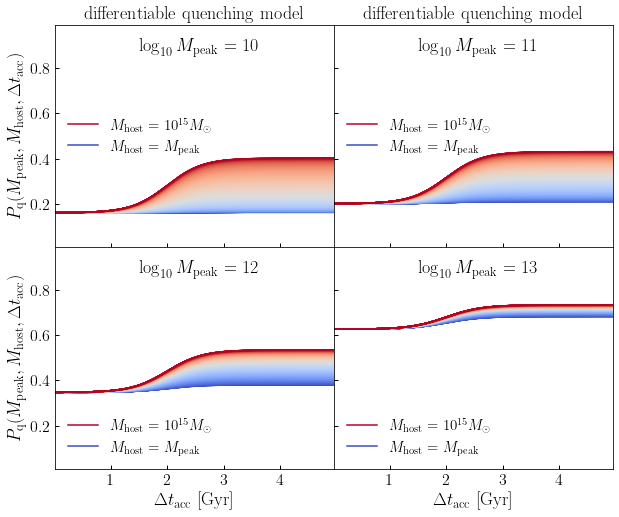

In [5]:
logmp_sats_plot = [10, 11, 12, 13]
blue_line = mlines.Line2D([],[],ls='-', c=colors[0], label=r'$M_{\rm host}=M_{\rm peak}$')
red_line = mlines.Line2D([],[],ls='-', c=colors[-1], label=r'$M_{\rm host}=10^{15}M_{\odot}$')

fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
((ax0, ax1), (ax2, ax3)) = _axes
axes = ax0, ax1, ax2, ax3
fig.subplots_adjust(wspace=0, hspace=0)
ylim = ax0.set_ylim(0.01, 0.99)
xlim = ax0.set_xlim(0.01, time_since_infall_arr.max()*0.99)

a, b = 1.5, 0.875

tarr = np.linspace(time_since_infall_arr.min(), time_since_infall_arr.max(), n_h)

for ax, logmp in zip(axes, logmp_sats_plot):
    logmhost_plot = np.linspace(logmp, 15, n_colors)
    for logmhost, c in zip(logmhost_plot, colors):
        qprob = sigmoid_quenching.quenching_prob_sats(zz+logmp, zz+logmhost, tarr)
        __=ax.plot(tarr, qprob, color=c)

leg = ax0.legend(handles=[red_line, blue_line], loc='center left')
leg = ax1.legend(handles=[red_line, blue_line], loc='center left')
leg = ax2.legend(handles=[red_line, blue_line], loc='lower left')
leg = ax3.legend(handles=[red_line, blue_line], loc='lower left')

        
__=ax0.annotate(r'$\log_{10}M_{\rm peak}=10$', xy=(a, b), xytext=(a, b), size=18)
__=ax1.annotate(r'$\log_{10}M_{\rm peak}=11$', xy=(a, b), xytext=(a, b), size=18)
__=ax2.annotate(r'$\log_{10}M_{\rm peak}=12$', xy=(a, b), xytext=(a, b), size=18)
__=ax3.annotate(r'$\log_{10}M_{\rm peak}=13$', xy=(a, b), xytext=(a, b), size=18)

xlabel = ax2.set_xlabel(r'$\Delta t_{\rm acc}\ {\rm [Gyr]}$')
xlabel = ax3.set_xlabel(r'$\Delta t_{\rm acc}\ {\rm [Gyr]}$')
ylabel = ax0.set_ylabel(r'$P_{\rm q}(M_{\rm peak}, M_{\rm host},\Delta t_{\rm acc})$')
ylabel = ax2.set_ylabel(r'$P_{\rm q}(M_{\rm peak}, M_{\rm host},\Delta t_{\rm acc})$')

title = ax0.set_title(r'${\rm differentiable\ quenching\ model}$')
title = ax1.set_title(r'${\rm differentiable\ quenching\ model}$')

fig.savefig('qprob_sats_vs_tacc.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200) 

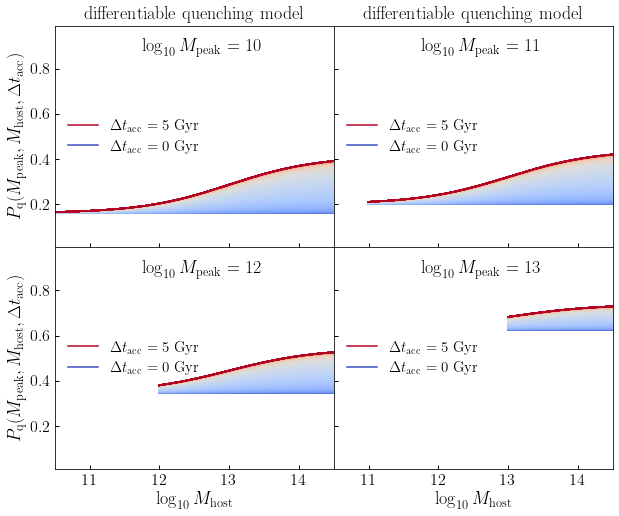

In [6]:
blue_line = mlines.Line2D([],[],ls='-', c=colors[0], label=r'$\Delta t_{\rm acc}=0\ {\rm Gyr}$')
red_line = mlines.Line2D([],[],ls='-', c=colors[-1], label=r'$\Delta t_{\rm acc}=5\ {\rm Gyr}$')


fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
((ax0, ax1), (ax2, ax3)) = _axes
axes = ax0, ax1, ax2, ax3
fig.subplots_adjust(wspace=0, hspace=0)
ylim = ax0.set_ylim(0.01, 0.99)
xlim = ax0.set_xlim(10.5, 14.5)

logmp_sats_plot = [10, 11, 12, 13]
a, b = 11.75, 0.875

for ax, logmp in zip(axes, logmp_sats_plot):
    logmhost = np.linspace(logmp, 15.5, n_h)
    for t, c in zip(time_since_infall_arr, colors):
        qprob = sigmoid_quenching.quenching_prob_sats(zz+logmp, logmhost, t)
        __=ax.plot(logmhost, qprob, color=c)
    leg = ax.legend(handles=[red_line, blue_line], loc='center left')
        
xlabel = ax2.set_xlabel(r'$\log_{10}M_{\rm host}$')
xlabel = ax3.set_xlabel(r'$\log_{10}M_{\rm host}$')
ylabel = ax0.set_ylabel(r'$P_{\rm q}(M_{\rm peak}, M_{\rm host},\Delta t_{\rm acc})$')
ylabel = ax2.set_ylabel(r'$P_{\rm q}(M_{\rm peak}, M_{\rm host},\Delta t_{\rm acc})$')

__=ax0.annotate(r'$\log_{10}M_{\rm peak}=10$', xy=(a, b), xytext=(a, b), size=18)
__=ax1.annotate(r'$\log_{10}M_{\rm peak}=11$', xy=(a, b), xytext=(a, b), size=18)
__=ax2.annotate(r'$\log_{10}M_{\rm peak}=12$', xy=(a, b), xytext=(a, b), size=18)
__=ax3.annotate(r'$\log_{10}M_{\rm peak}=13$', xy=(a, b), xytext=(a, b), size=18)

title = ax0.set_title(r'${\rm differentiable\ quenching\ model}$')
title = ax1.set_title(r'${\rm differentiable\ quenching\ model}$')

fig.savefig('qprob_sats_vs_mhost.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200) 